In [2]:
import sys
sys.path.append("../pysktb")
from pysktb import *
import pymatgen as pymat
from pymatgen.symmetry.kpath import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [3]:
p=pymat.Structure.from_file("Cssii2.cif") 

In [4]:
def get_ham(soc=0.3):
    atoms=[]
    for i in p[1:]:
        atoms.append(Atom(i.species_string,i.frac_coords))
    for i in atoms:
        i.set_orbitals(["px","py","pz"])
    atoms[0].set_orbitals(["s","px","py","pz"])
    lattice=Lattice(p.lattice.matrix,1)
    d=.8
    interactions={  "Si":{"e_s":d,"e_p":[d,d,d],"lambda":soc}
                    ,"I":{"e_p":[-d,-d,-d]}
                    ,"SiI":{"V_sps":1,"V_ppp":-.5,"V_pps":2}
                    ,"II":{"V_ppp":0,"V_pps":0}
                    ,"SiSi":{"V_ppp":0,"V_pps":0}}
    nn=p.get_distance(1,2)
    bond={"SiI":{"NN":nn+1}
         ,"II":{"NN":nn+1.2}
         ,"SiSi":{"NN":nn+1}}
    s=Structure(lattice,atoms,bond_cut=bond)
    ham=Hamiltonian(s,interactions,numba=1)
    return ham

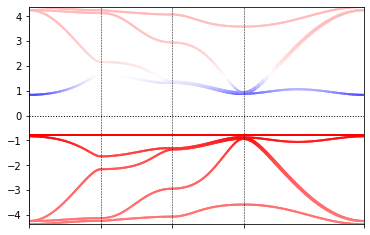

In [14]:
ham=get_ham(soc=0.0)

k_path=KPathLatimerMunro(p).get_kpoints(coords_are_cartesian=True)


path=[[0.,0.,0],[0.5,0,0],[0.5,.5,0],[0,0,0],[.5,.5,.5],[0,.5,0]]
X=[0.5,0,0]
G=[0,0,0]
M=[.5,.5,0]
R=[.5,.5,.5]
orbs=ham.orbital_order
path=[G,X,M,R,G]

k_path, k_dist,k_pts=ham.get_kpts(path,30)
evals,vecs=ham.solve_kpath(k_path, eig_vectors=True)
fig,ax=plt.subplots()
index=[i for i in orbs if "I" in orbs[i]]
ham.plot_kproj(evals,vecs,k_dist,index=index,ax=ax)
ax.set_xticks(k_pts)
ax.set_xticklabels([""])
for i in k_pts:ax.axvline(i,c="k",ls="--",lw=.5)
plt.show()

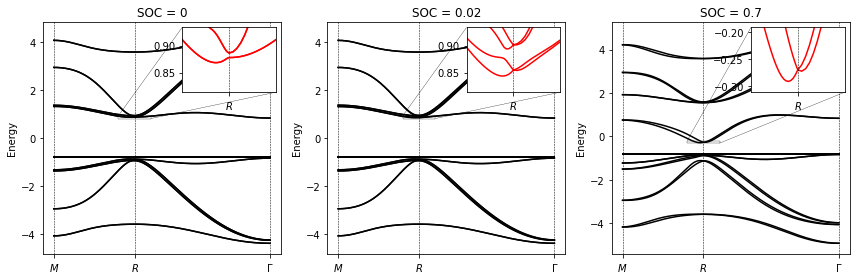

In [20]:
SOC=[0,.02,.7]
fig,ax1=plt.subplots(1,len(SOC),figsize=(len(SOC)*4,4))
for i,j in enumerate(SOC):
    ham=get_ham(soc=j)
    path=[M,R,G]
    label=["$M$","$R$","$\Gamma$"]
    k_path, k_dist,k_pts=ham.get_kpts(path,100)
    evals,vecs=ham.solve_kpath(k_path, eig_vectors=True)
    
    #----plotting
    ax=ax1[i]
    for i in evals:ax.plot(k_dist,i,c="k")
    ax.set_xticks(k_pts)
    ax.set_xticklabels(label)
    for i in k_pts:ax.axvline(i,c="k",ls="--",lw=.5)
    ax.set_ylabel("Energy")
    ax.set_title("SOC = {}".format(j))
    #----plot inset
    ax_in= inset_axes(ax, width=1.3, height=0.9)
    mark_inset(ax, ax_in, loc1=4, loc2=2, fc="none", lw=.3, ec='k')
    for i in evals:ax_in.plot(k_dist,i,c="r")
    ax_in.set_xticks(k_pts)
    ax_in.set_xticklabels(label)
    for i in k_pts:
        ax_in.axvline(i,c="k",ls="--",lw=.5)
    ax_in.set_ylim([evals[18].min()-.02,evals[18].min()+.1])
    ax_in.set_xlim(k_pts[1]*.8,k_pts[1]*1.2)
plt.tight_layout()
plt.show()

In [25]:
%%timeit
ham=get_ham(soc=.2)
vals=[]
vals.append(ham.total_energy(filled_band=17,nk=20))


10.2 s ± 1.44 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
20*20*20

8000